In [46]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats as stats

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import train_test_split, GridSearchCV,\
cross_val_score, RandomizedSearchCV

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from pandas_profiling import ProfileReport

from sklearn.compose import ColumnTransformer,  make_column_selector as selector
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from imblearn.over_sampling import SMOTE, SMOTENC
from imblearn.pipeline import Pipeline as ImPipeline

from sklearn.metrics import plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score
from sklearn.metrics import roc_curve

from numpy import sqrt
from numpy import argmax
from sklearn.preprocessing import RobustScaler

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [33]:
df.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [3]:
robust_scaler = RobustScaler()

df['scaled_amount'] = robust_scaler.fit_transform(df.Amount.values.reshape(-1,1))
df['scaled_time'] = robust_scaler.fit_transform(df.Time.values.reshape(-1,1))

df.drop(['Time', 'Amount'], axis = 1, inplace = True)

In [4]:
y = df['Class']
X = df.drop('Class', axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 42)

In [5]:
y_train.value_counts(normalize=True)

0    0.998226
1    0.001774
Name: Class, dtype: float64

In [ ]:
dummy_model_pipe = Pipeline(steps=[
    ('dum', DummyClassifier(strategy='most_frequent'))
])

In [6]:
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax

In [ ]:
dummy_pipe = ModelWithCV(dummy_model_pipe, 'dummy_model', X_train, y_train)

In [ ]:

dummy_pipe.print_cv_summary()

In [34]:
logreg_model_pipe = Pipeline([
    ('logreg', LogisticRegression(random_state=42, max_iter=1000))
])

In [35]:
logreg_pipe = ModelWithCV(logreg_model_pipe, 'logreg_model', X_train, y_train)

In [36]:
logreg_pipe.print_cv_summary()

CV Results for `logreg_model` model:
            0.99921 ± 0.00012 accuracy
        


In [37]:
logreg_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('logreg', LogisticRegression(max_iter=1000, random_state=42))])

In [38]:
lr_y_hat = logreg_model_pipe.predict(X_test)

In [39]:
print(f"""
Our model's accuracy on the test set is {round(accuracy_score(y_test, lr_y_hat), 2)}. \n
Our model's recall on the test set is {round(recall_score(y_test, lr_y_hat), 2)} \n
Our model's precision on the test set is {round(precision_score(y_test, lr_y_hat), 2)} \n
Our model's f1-score on the test is {round(f1_score(y_test, lr_y_hat), 2)}.
""")


Our model's accuracy on the test set is 1.0. 

Our model's recall on the test set is 0.6 

Our model's precision on the test set is 0.85 

Our model's f1-score on the test is 0.7.



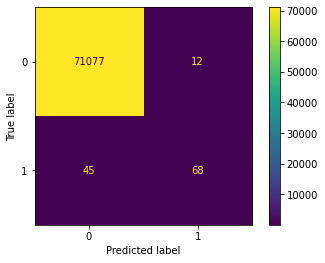

In [48]:
plot_confusion_matrix(logreg_model_pipe, X_test, y_test);

In [41]:
imb_pipe = ImPipeline(steps=[
    ('sm', SMOTE(sampling_strategy='auto', random_state=42)),
    ('log', LogisticRegression(random_state=42, max_iter=1000))
])

In [42]:
imb_pipe.fit(X_train, y_train)

Pipeline(steps=[('sm', SMOTE(random_state=42)),
                ('log', LogisticRegression(max_iter=1000, random_state=42))])

In [43]:
y_hat = imb_pipe.predict(X_test)

In [44]:
print(f"""
Our model's accuracy on the test set is {round(accuracy_score(y_test, y_hat), 2)}. \n
Our model's recall on the test set is {round(recall_score(y_test, y_hat), 2)} \n
Our model's precision on the test set is {round(precision_score(y_test, y_hat), 2)} \n
Our model's f1-score on the test is {round(f1_score(y_test, y_hat), 2)}.
""")


Our model's accuracy on the test set is 0.97. 

Our model's recall on the test set is 0.93 

Our model's precision on the test set is 0.05 

Our model's f1-score on the test is 0.1.



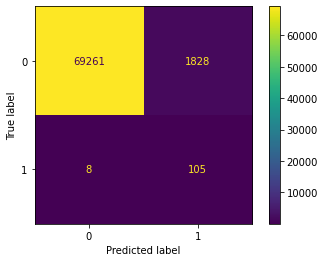

In [47]:
plot_confusion_matrix(imb_pipe, X_test, y_test);

It seems that with the SMOTE data appears to do worse but it actually preforms better because only 8 cases of fraud are predicted as not fraud which means that, sure a few more isntances of fraud are reported but less people get away with fraud.